In [1]:
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from torch.utils.data import Dataset,DataLoader
from sklearn import manifold,metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from matplotlib import pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
#import ctypes
#ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

In [3]:
import kaldi_io

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [4]:
def pad(array, reference):
    
    # Create an array of zeros with the reference shape
    result = np.zeros(reference.shape)
        
    if array.shape[0] <= reference.shape[0]:
        # Insert the array in the result at the specified offsets
        result[:array.shape[0],:array.shape[1]] = array
        return result
    
    else:
        result[:,:] = array[:result.shape[0],:result.shape[1]]
        return result
        

(array([415., 653., 605., 585., 570., 410., 132.,  49.,  21.,   9.]),
 array([ 3. , 12.6, 22.2, 31.8, 41.4, 51. , 60.6, 70.2, 79.8, 89.4, 99. ]),
 <a list of 10 Patch objects>)

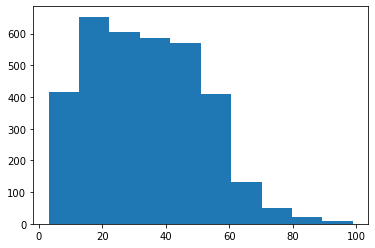

In [5]:
plt.hist([np.shape(mat)[0] for key,mat in kaldi_io.read_mat_ark('word_mfcc_features.ark')], bins = 10)

In [6]:
shapes = [np.shape(mat)[0] for key,mat in kaldi_io.read_mat_ark('word_mfcc_features.ark')]

In [7]:
max(shapes)

99

mat_sizes = []
keys = []
mats = []

reference = np.zeros((100,40))
for key,mat in kaldi_io.read_mat_ark('word_mfcc_features.ark'):
    count+=1
    #print(mat.shape)
    mat_sizes.append(mat.shape[0])
    keys.append(key.split('_')[1])
    mats.append(pad(mat,reference).T)
    #mats.append(mat.T)
print(len(keys))

In [8]:
#Load the data
keys = []
matrices = []
mat_lengths = []

for key,matrix in kaldi_io.read_mat_ark('word_mfcc_features.ark'):
    keys.append(key.split('_')[1])
    matrices.append(matrix)
    mat_lengths.append(matrix.shape[0])
print(len(keys))

3449


In [9]:
# Function to truncate and limit dimensionality
def truncate_shapes(matrices,mat_lengths,max_length = 100,num_mfcc_features = 40):
    
    for i, seq in enumerate(matrices):
        matrices[i] = matrices[i][:max_length, :num_mfcc_features]
        mat_lengths[i] = min(mat_lengths[i], max_length)
    
    return matrices,mat_lengths 

In [10]:
#Truncate the dimensions of the data
matrices,mat_lengths = truncate_shapes(matrices,mat_lengths,max_length=100,num_mfcc_features=40)

In [11]:
for mat in matrices:
    print(mat.shape)

(12, 40)
(42, 40)
(30, 40)
(33, 40)
(36, 40)
(63, 40)
(60, 40)
(87, 40)
(36, 40)
(15, 40)
(15, 40)
(12, 40)
(27, 40)
(75, 40)
(15, 40)
(48, 40)
(27, 40)
(15, 40)
(36, 40)
(39, 40)
(48, 40)
(36, 40)
(54, 40)
(12, 40)
(45, 40)
(63, 40)
(48, 40)
(21, 40)
(48, 40)
(24, 40)
(27, 40)
(48, 40)
(42, 40)
(42, 40)
(57, 40)
(12, 40)
(9, 40)
(24, 40)
(45, 40)
(15, 40)
(57, 40)
(33, 40)
(36, 40)
(12, 40)
(30, 40)
(21, 40)
(45, 40)
(30, 40)
(48, 40)
(33, 40)
(12, 40)
(45, 40)
(42, 40)
(15, 40)
(75, 40)
(15, 40)
(21, 40)
(30, 40)
(54, 40)
(36, 40)
(54, 40)
(51, 40)
(99, 40)
(54, 40)
(9, 40)
(42, 40)
(72, 40)
(42, 40)
(39, 40)
(45, 40)
(45, 40)
(42, 40)
(33, 40)
(54, 40)
(48, 40)
(27, 40)
(45, 40)
(45, 40)
(81, 40)
(15, 40)
(72, 40)
(18, 40)
(9, 40)
(27, 40)
(36, 40)
(33, 40)
(42, 40)
(66, 40)
(15, 40)
(21, 40)
(39, 40)
(18, 40)
(33, 40)
(51, 40)
(48, 40)
(63, 40)
(18, 40)
(48, 40)
(60, 40)
(15, 40)
(39, 40)
(45, 40)
(72, 40)
(48, 40)
(33, 40)
(57, 40)
(18, 40)
(33, 40)
(30, 40)
(48, 40)
(45, 40)
(30,

(30, 40)
(48, 40)
(42, 40)
(15, 40)
(39, 40)
(42, 40)
(24, 40)
(33, 40)
(24, 40)
(42, 40)
(57, 40)
(42, 40)
(15, 40)
(27, 40)
(33, 40)
(30, 40)
(45, 40)
(18, 40)
(15, 40)
(21, 40)
(30, 40)
(30, 40)
(30, 40)
(36, 40)
(63, 40)
(24, 40)
(66, 40)
(15, 40)
(33, 40)
(75, 40)
(12, 40)
(48, 40)
(9, 40)
(48, 40)
(18, 40)
(9, 40)
(27, 40)
(30, 40)
(57, 40)
(15, 40)
(27, 40)
(6, 40)
(45, 40)
(45, 40)
(30, 40)
(45, 40)
(12, 40)
(48, 40)
(39, 40)
(18, 40)
(42, 40)
(63, 40)
(12, 40)
(45, 40)
(54, 40)
(48, 40)
(57, 40)
(18, 40)
(51, 40)
(60, 40)
(51, 40)
(51, 40)
(87, 40)
(42, 40)
(15, 40)
(36, 40)
(39, 40)
(15, 40)
(24, 40)
(57, 40)
(33, 40)
(33, 40)
(48, 40)
(15, 40)
(9, 40)
(42, 40)
(24, 40)
(27, 40)
(48, 40)
(27, 40)
(18, 40)
(57, 40)
(15, 40)
(27, 40)
(45, 40)
(87, 40)
(30, 40)
(33, 40)
(30, 40)
(24, 40)
(30, 40)
(51, 40)
(12, 40)
(30, 40)
(27, 40)
(30, 40)
(6, 40)
(42, 40)
(12, 40)
(21, 40)
(57, 40)
(6, 40)
(36, 40)
(24, 40)
(30, 40)
(30, 40)
(30, 40)
(45, 40)
(15, 40)
(45, 40)
(30, 40)
(45, 40

(30, 40)
(51, 40)
(30, 40)
(18, 40)
(15, 40)
(30, 40)
(42, 40)
(72, 40)
(69, 40)
(48, 40)
(84, 40)
(36, 40)
(15, 40)
(33, 40)
(69, 40)
(30, 40)
(9, 40)
(48, 40)
(39, 40)
(12, 40)
(15, 40)
(36, 40)
(24, 40)
(45, 40)
(51, 40)
(12, 40)
(42, 40)
(30, 40)
(45, 40)
(51, 40)
(24, 40)
(60, 40)
(9, 40)
(12, 40)
(36, 40)
(87, 40)
(36, 40)
(93, 40)
(48, 40)
(39, 40)
(66, 40)
(18, 40)
(36, 40)
(39, 40)
(72, 40)
(42, 40)
(30, 40)
(57, 40)
(45, 40)
(39, 40)
(33, 40)
(30, 40)
(57, 40)
(54, 40)
(54, 40)
(75, 40)
(21, 40)
(18, 40)
(39, 40)
(27, 40)
(63, 40)
(18, 40)
(27, 40)
(12, 40)
(72, 40)
(30, 40)
(51, 40)
(60, 40)
(66, 40)
(18, 40)
(45, 40)
(33, 40)
(33, 40)
(12, 40)
(54, 40)
(30, 40)
(18, 40)
(3, 40)
(54, 40)
(9, 40)
(42, 40)
(30, 40)
(27, 40)
(51, 40)
(18, 40)
(24, 40)
(51, 40)
(27, 40)
(39, 40)
(45, 40)
(45, 40)
(15, 40)
(42, 40)
(21, 40)
(24, 40)
(60, 40)
(27, 40)
(36, 40)
(72, 40)
(39, 40)
(39, 40)
(15, 40)
(51, 40)
(51, 40)
(33, 40)


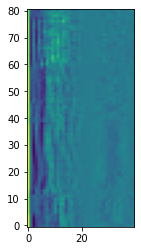

In [12]:
#See how a random matrix looks
plt.imshow(matrices[689], origin="bottom");

In [13]:
#Function for padding
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]))
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

In [14]:
matrices,mat_lengths = pad_sequences(matrices,n_padded = 100,center_padded = True)
matrices = np.transpose(matrices,(0,2,1))

In [15]:
matrices.shape

(3449, 40, 100)

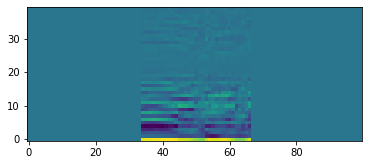

In [16]:
#See how a random matrix looks
plt.imshow(matrices[200], origin="bottom");

In [17]:

c = Counter(keys)
#print(c)
num_words = len(c.keys())
word_to_num = {}
num_to_word = {}

index = 0
for key in c.keys():
    word_to_num[key] = index
    num_to_word[index] = key
    index+=1

label_list = []
for key in keys:
    label_list.append(word_to_num[key])

print(len(c.keys()))

981


In [18]:
print(c)

Counter({'THE': 145, 'TO': 87, 'IN': 61, 'OF': 53, 'AND': 48, 'POINT': 43, 'A': 42, 'THREE': 41, 'PERCENT': 37, 'ONE': 36, 'THAT': 34, 'COMPANY': 33, 'HUNDRED': 33, 'ON': 33, 'FIVE': 28, 'SIX': 27, 'TWO': 26, 'FOR': 25, 'AT': 25, 'DOLLARS': 25, 'SAID': 24, 'WAS': 24, 'MILLION': 24, 'SEVEN': 22, 'IS': 21, 'AS': 20, 'ARE': 20, 'NEW': 19, 'IT': 19, 'FROM': 18, 'WITH': 18, 'ABOUT': 18, 'TWENTY': 17, 'BE': 17, 'ITS': 16, 'FOUR': 16, 'HE': 16, 'NINETEEN': 16, 'THOUSAND': 16, 'BUT': 16, 'NINE': 15, 'STOCK': 15, 'SHARES': 14, 'HAS': 13, 'WERE': 13, 'BY': 13, 'HAVE': 13, 'EIGHT': 13, 'FORTY': 13, 'FIFTY': 13, 'ANALYSTS': 12, 'YEAR': 11, 'WOULD': 11, 'WILL': 11, 'EIGHTY': 11, 'MAY': 11, 'THIRTY': 10, 'THEY': 10, 'SHARE': 10, 'NINETY': 10, 'ROSE': 9, 'LAST': 9, 'SEVENTY': 9, 'WE': 9, 'AFTER': 9, 'EXCHANGE': 9, 'YORK': 9, 'AN': 8, 'THEIR': 8, 'COMPANIES': 8, 'WHICH': 8, 'UP': 8, 'THIS': 8, 'QUARTER': 8, 'INDEX': 8, 'SOME': 8, 'HAD': 8, 'OTHER': 7, 'BIG': 7, 'BUSINESS': 7, 'AUCTION': 7, 'OR': 7, 'L

In [19]:
print([(word,c[word]) for word in sorted(c.keys())])

[('A', 42), ('ABOUT', 18), ('ABOVE', 3), ('ACCEPTED', 1), ('ACCEPTS', 1), ('ACCORDING', 3), ('ACQUIRE', 2), ('ACROSS', 1), ('ACT', 2), ('ACTION', 1), ('ACTUAL', 2), ('ADDITIONAL', 1), ('ADDS', 1), ('ADMINISTRATION', 2), ('ADVANCING', 2), ('ADVISER', 3), ('AFFECT', 1), ('AFFECTED', 2), ('AFFILIATE', 2), ('AFTER', 9), ('AFTERNOON', 1), ('AGAIN', 2), ('AGENCY', 1), ('AGGREGATE', 1), ('AGREE', 1), ('AGREEMENT', 2), ('AGRICULTURAL', 1), ('AIMED', 2), ('AIMING', 1), ('AIRCRAFT', 2), ('AIRING', 3), ('AIRLINE', 1), ('AIRLINES', 2), ('ALL', 6), ('ALMOST', 1), ('ALREADY', 3), ('ALSO', 7), ('ALTHOUGH', 2), ('AMAZINGLY', 1), ('AMERICA', 1), ('AMERICAN', 6), ('AMONG', 4), ('AMOUNT', 1), ('AN', 8), ('ANALYST', 1), ('ANALYSTS', 12), ('AND', 48), ('ANNUALLY', 1), ('ANOTHER', 1), ('ANTICIPATED', 2), ('ANY', 2), ('APPEAL', 1), ('ARE', 20), ('ARGUMENTS', 1), ('ARIZONA', 1), ('AROUND', 2), ('ARRANGED', 1), ('ARRANGEMENT', 1), ('AS', 20), ('ASHLAND', 1), ('ASKING', 1), ('ASPECTS', 1), ('ASSETS', 3), ('ASSU

In [20]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
inputs = np.stack(matrices)
inputs = np.expand_dims(inputs,1)
labels = np.array(label_list)
print(inputs.shape)
print(labels.shape)


(3449, 1, 40, 100)
(3449,)


In [22]:
x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

In [23]:
x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 42)

In [24]:
x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)

In [25]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

torch.Size([2069, 1, 40, 100]) torch.Size([2069])
torch.Size([690, 1, 40, 100]) torch.Size([690])
torch.Size([690, 1, 40, 100]) torch.Size([690])


In [26]:
x_train[20].squeeze()[0]

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000, 101.9694,  98.7186,  88.2952,  80.9519,  80.3870,
         79.6338,  85.4708,  88.2952,  93.0024,  92.8141,  91.3078,  97.0933,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

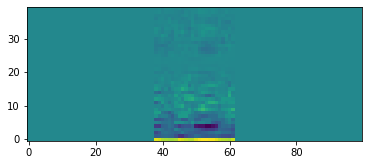

In [27]:
plt.imshow(x_train[10].squeeze(), origin = "bottom")

In [28]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True)

In [29]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1,96,(40,10))
        self.pool = nn.MaxPool2d(1, 3)
        self.conv2 = nn.Conv2d(96, 96, (1,8))
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        return x.detach().numpy()




In [53]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv2d(1,96,(40,10))
        self.pool = nn.MaxPool2d(1, 3)
        self.conv2 = nn.Conv2d(96, 96, (1,8))
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()




In [54]:
#net = SimpleNet()
net = SiameseNet()
net = net.float()
net.to(dev)

SiameseNet(
  (conv1): Conv2d(1, 96, kernel_size=(40, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 96, kernel_size=(1, 8), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=981, bias=True)
  (sm): Softmax(dim=1)
)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [56]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [57]:
def train_model(net,num_epochs,train_dl,val_dl,save_path = "./models/"):
    
    best_val_loss = np.Inf
    best_val_acc = np.NINF
    for epoch in range(0,num_epochs):  # loop over the dataset multiple times
        print('epoch %d '%(epoch))

        train_loss = 0
        train_acc = 0
        net.train()
        for xb,yb in train_dl:
            
            #Move to GPU
            xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
            
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = torch.tensor(inputs),torch.tensor(labels)
            #labels = labels.long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(xb)
            loss = criterion(outputs, yb.long())
            train_loss += loss.item()
            train_acc += accuracy(outputs,yb)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = loss.item()
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for xb,yb in val_dl:
                
                #Move to GPU
                xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
                
                val_loss += criterion(net(xb),yb.long())
                val_acc += accuracy(net(xb), yb.long())
            #val_loss = sum(criterion(net(xb), yb.long()) for xb, yb in val_dl)
            #val_acc = sum(accuracy(net(xb), yb.long()) for xb, yb in val_dl)
            if val_acc.cpu().detach().numpy() > best_val_acc:
                best_val_acc = val_acc.cpu().detach().numpy()
                path = save_path + "best_model.pth"
                print("Best val acc. Saving model...")
                torch.save(net.state_dict(), path)


        print("train loss: %.3f train acc: %.3f"%(train_loss/len(train_dl),train_acc/len(train_dl)))
        print("val loss: %.3f val acc: %.3f"%(val_loss/len(val_dl),val_acc/len(val_dl)))
        if epoch%5 == 0:
            path = save_path + "simple_awe_bs64_epoch_%d.pth"%(epoch)
            torch.save(net.state_dict(), path)


    print('Finished Training')

In [58]:
def evaluate_model(net,features,labels, diagonal_pairs = True):
    
    #If device is GPU move features to GPU
    if dev.type == 'cuda':
        features = features.to(dev, non_blocking = True)
    
    #Get the embeddings
    embeddings = net.give_embeddings(features)
    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')
    
    
    
    #Create labels of whether the words are same or not
    if torch.is_tensor(labels):
        labels = labels.detach().numpy()
        
    eval_labels = (labels[:,None]==labels).astype(float)
    
    
    if not diagonal_pairs:
        #Remove the diagonal elements (word pairs with themselves)
        #mask = ~np.eye(similarity.shape[0],dtype = bool)
        mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0])),-1),dtype = bool)
        similarity = similarity[mask]
        distances = distances[mask]
        eval_labels = eval_labels[mask]
        
    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)
    
    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    #avg_p = average_precision_score(eval_labels,similarity)
    avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    print('Average Precision is %f'%(avg_p))

            
            

In [59]:
train = True

In [60]:
if train:
    train_model(net,100,train_dl,val_dl,save_path="./models/")
else:
    print('Not training the model')

epoch 0 
Best val acc. Saving model...
train loss: 6.827 train acc: 0.020
val loss: 6.668 val acc: 0.055
epoch 1 
Best val acc. Saving model...
train loss: 6.474 train acc: 0.056
val loss: 6.276 val acc: 0.066
epoch 2 
Best val acc. Saving model...
train loss: 6.080 train acc: 0.065
val loss: 5.988 val acc: 0.089
epoch 3 
train loss: 5.808 train acc: 0.085
val loss: 5.870 val acc: 0.088
epoch 4 
Best val acc. Saving model...
train loss: 5.621 train acc: 0.104
val loss: 5.788 val acc: 0.091
epoch 5 
Best val acc. Saving model...
train loss: 5.430 train acc: 0.126
val loss: 5.684 val acc: 0.114
epoch 6 
Best val acc. Saving model...
train loss: 5.208 train acc: 0.154
val loss: 5.553 val acc: 0.138
epoch 7 
Best val acc. Saving model...
train loss: 4.936 train acc: 0.200
val loss: 5.413 val acc: 0.183
epoch 8 
Best val acc. Saving model...
train loss: 4.631 train acc: 0.254
val loss: 5.275 val acc: 0.196
epoch 9 
Best val acc. Saving model...
train loss: 4.309 train acc: 0.293
val loss: 5

train loss: 1.645 train acc: 0.762
val loss: 4.735 val acc: 0.343
epoch 99 
train loss: 1.645 train acc: 0.762
val loss: 4.738 val acc: 0.344
Finished Training


In [61]:
#Load the best model
best_model_path = "./models/best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [62]:
print(dev.type == 'cuda')

True


In [63]:
if dev.type == 'cuda':
    y_pred = net(x_test.to(dev, non_blocking = True))
    test_acc = accuracy(y_pred,y_test.to(dev, non_blocking = True).long())
elif dev.type == 'cpu':
    y_pred = net(x_test)
    test_acc = accuracy(y_pred,y_test.long())
    
print("Test Accuracy of best model is %.3f"%(test_acc))

Test Accuracy of best model is 0.346


In [64]:
evaluate_model(net,x_test,y_test,diagonal_pairs = False)

The number of positive examples 1456 and negative examples 236249
Average Precision is 0.102378


In [65]:
#Whether to retrain the model on train+test data
retrain_on_traintest = True

In [67]:
if retrain_on_traintest:
    #Get the traintest data by mergin training and test data
    x_traintest = np.vstack((x_train.numpy().squeeze(),x_test.numpy().squeeze()))
    y_traintest = np.concatenate((y_train.numpy(),y_test.numpy()),axis=0)

    x_traintest = np.expand_dims(x_traintest,1)

    x_traintest = torch.tensor(x_traintest,dtype = torch.float)
    y_traintest = torch.tensor(y_traintest,dtype = torch.float)

    print(x_traintest.shape)
    print(y_traintest.shape)
    
    #Create traintest Dataset and Dataloader
    bs = 64
    traintest_ds = TensorDataset(x_traintest, y_traintest)
    traintest_dl = DataLoader(traintest_ds, batch_size=bs, pin_memory = True)
    
    #Train on training and test data, use validation to select the best model
    train_model(net,100,traintest_dl,val_dl,save_path = "./models/traintest/")
    #Load the best model
    best_model_path = "./models/traintest/best_model.pth"
    net.load_state_dict(torch.load(best_model_path))
else:
    print('Not retraining')

torch.Size([2759, 1, 40, 100])
torch.Size([2759])
epoch 0 
Best val acc. Saving model...
train loss: 2.614 train acc: 0.634
val loss: 5.563 val acc: 0.234
epoch 1 
Best val acc. Saving model...
train loss: 3.347 train acc: 0.497
val loss: 4.808 val acc: 0.282
epoch 2 
Best val acc. Saving model...
train loss: 2.796 train acc: 0.597
val loss: 4.608 val acc: 0.307
epoch 3 
train loss: 2.516 train acc: 0.638
val loss: 4.592 val acc: 0.300
epoch 4 
Best val acc. Saving model...
train loss: 2.426 train acc: 0.651
val loss: 4.526 val acc: 0.327
epoch 5 
train loss: 2.372 train acc: 0.662
val loss: 4.582 val acc: 0.325
epoch 6 
train loss: 2.342 train acc: 0.664
val loss: 4.599 val acc: 0.321
epoch 7 
train loss: 2.319 train acc: 0.667
val loss: 4.581 val acc: 0.324
epoch 8 
train loss: 2.307 train acc: 0.670
val loss: 4.638 val acc: 0.316
epoch 9 
train loss: 2.295 train acc: 0.670
val loss: 4.645 val acc: 0.323
epoch 10 
train loss: 2.284 train acc: 0.673
val loss: 4.641 val acc: 0.322
epoc

In [68]:
evaluate_model(net,x_test,y_test,diagonal_pairs = False)

The number of positive examples 1456 and negative examples 236249
Average Precision is 0.126779


In [ ]:
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [ ]:
def give_tsne(net,inputs):
    
    embeddings = net.give_embeddings(inputs)
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [ ]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [ ]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [ ]:
tsne_vectors = give_tsne(net,torch.tensor(inputs,dtype=torch.float))

In [ ]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

In [ ]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

In [ ]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels)

In [ ]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

In [ ]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

In [ ]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

In [ ]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

In [ ]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [ ]:
def nearest_neighbors(net,inputs,labels,n_neighbors = 3):
    
    embeddings = net.give_embeddings(inputs)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute',metric = 'cosine').fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [ ]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [ ]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [ ]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "ACCEPTS"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "RANGE"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
word = "THAN"
nearest_neighbors_for_word(word,indices,labels)

In [ ]:
def filter_infrequent_words(labels,threshold = 2):
    '''For a given list of labels, returns index of frequent words 
    (words having frequency greater than or equal to the threshold)
    '''
    if torch.is_tensor(labels):
        label_counter = Counter(labels.detach().numpy())
    else:
        label_counter = Counter(labels)
    print('Number of unique words in labels %d'%(len(word_counter)))
    
    #Remove infrequent words from the Counter
    for key,value in tuple(label_counter.items()):
        if not (value>=threshold):
            label_counter.pop(key)
    print('Number of unique words with frequency atleast %d is %d'%(threshold,len(word_counter)))
    
    #Get the labels for the frequent words
    frequent_word_labels = np.array(tuple(label_counter.keys()))
    frequent_word_indices = np.where(np.isin(labels,frequent_word_labels))
    
    return frequent_word_indices,frequent_word_labels

In [ ]:
#frequent_word_indices,frequent_word_labels = filter_infrequent_words(y_train)